**Project Colon Cancer  Detection :**

 **Install libraries :**

In [ ]:
!pip install tensorflow==2.9.1

 **Import libraries**

In [ ]:
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import system libs
import os
import time
import shutil
import pathlib
import itertools



# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')




modules loaded


**Load Data**

In [ ]:
#get the data from drive :
!cp /content/drive/MyDrive/Colab\ Notebooks/colon_image_set.zip /content/



In [ ]:
!unzip /content/colon_image_set.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: colon_image_sets/colon_n/colonn1.jpeg  
  inflating: colon_image_sets/colon_n/colonn10.jpeg  
  inflating: colon_image_sets/colon_n/colonn100.jpeg  
  inflating: colon_image_sets/colon_n/colonn1000.jpeg  
  inflating: colon_image_sets/colon_n/colonn1001.jpeg  
  inflating: colon_image_sets/colon_n/colonn1002.jpeg  
  inflating: colon_image_sets/colon_n/colonn1003.jpeg  
  inflating: colon_image_sets/colon_n/colonn1004.jpeg  
  inflating: colon_image_sets/colon_n/colonn1005.jpeg  
  inflating: colon_image_sets/colon_n/colonn1006.jpeg  
  inflating: colon_image_sets/colon_n/colonn1007.jpeg  
  inflating: colon_image_sets/colon_n/colonn1008.jpeg  
  inflating: colon_image_sets/colon_n/colonn1009.jpeg  
  inflating: colon_image_sets/colon_n/colonn101.jpeg  
  inflating: colon_image_sets/colon_n/colonn1010.jpeg  
  inflating: colon_image_sets/colon_n/colonn1011.jpeg  
  inflating: colon_image_sets/col

**Helpers Function:**

In [ ]:
def generate_data(path_dir):
  filepaths = []# pour enregistrer les chemins d'images
  labels = []# represente l'appartenance des images aux classes

  dirs = os.listdir(path_dir) # lister tous les éléments présents dans le répertoire "data_dir"
  for dir in dirs:
      foldpath = os.path.join(path_dir, dir)
      filelist = os.listdir(foldpath)
      for file in filelist:
          fpath = os.path.join(foldpath, file)
          filepaths.append(fpath)
          labels.append(dir)

  df=pd.DataFrame({'filepaths': filepaths, 'labels': labels})
  return df


In [ ]:
# Generate data paths with labels
path_dir = '/content/colon_image_sets'
df =  generate_data(path_dir)

In [ ]:
df

,filepaths,labels
0,/content/colon_image_sets/colon_aca/colonca163...,colon_aca
1,/content/colon_image_sets/colon_aca/colonca443...,colon_aca
2,/content/colon_image_sets/colon_aca/colonca370...,colon_aca
3,/content/colon_image_sets/colon_aca/colonca298...,colon_aca
4,/content/colon_image_sets/colon_aca/colonca433...,colon_aca
...,...,...
9995,/content/colon_image_sets/colon_n/colonn1035.jpeg,colon_n
9996,/content/colon_image_sets/colon_n/colonn2614.jpeg,colon_n
9997,/content/colon_image_sets/colon_n/colonn4853.jpeg,colon_n
9998,/content/colon_image_sets/colon_n/colonn2553.jpeg,colon_n


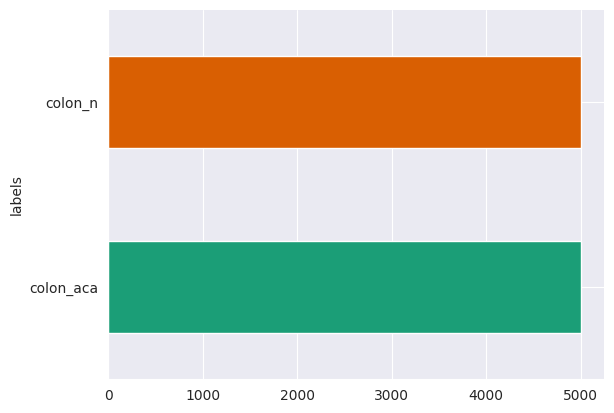

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df['labels'].value_counts()

labels
colon_aca    5000
colon_n      5000
Name: count, dtype: int64

 **Split data :**


*   80% for training
*   10% for validation  
*   10% for testing



In [ ]:
import math

def dataFolder(p, split):
# we create a  folder
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)
        for dir in os.listdir (ROOT_DIR):
          os.makedirs("./"+p+"/"+dir)
          for img in np.random.choice (a=os.listdir(os.path.join(ROOT_DIR, dir)),
                                       size= (math.floor(split *number_of_images [dir])-5),
                                       replace=False ):
                    O = os.path.join(ROOT_DIR, dir, img)
                    D=os.path.join("./"+p,dir)
                    shutil.copy(O,D)
                    os.remove(O)
    else :
         print(f" {p}  Folder exsist")

In [ ]:
ROOT_DIR= '/content/colon_image_sets'
number_of_images={}
for dir in os.listdir(ROOT_DIR):
     number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

In [ ]:
number_of_images

{'colon_aca': 5000, 'colon_n': 5000}

In [ ]:
dataFolder("train",0.8)

In [ ]:
dataFolder("valid",0.1)

In [ ]:
dataFolder("test",0.1)


In [ ]:
path_dir = '/content/train'
train_df = generate_data(path_dir)

In [ ]:

path_dir = '/content/valid'
valid_df = generate_data(path_dir)

In [ ]:
path_dir = '/content/test'
test_df = generate_data(path_dir)

df.shape

In [ ]:
valid_df.shape

(990, 2)

In [ ]:
test_df.shape

(990, 2)

In [ ]:
train_df['labels'].value_counts()

labels
colon_aca    3995
colon_n      3995
Name: count, dtype: int64

**Data** **Preprocessing** :

In [ ]:
# Definition of batch size for training and inference
batch_size = 16

# Definition of image shape
img_shape = (224, 224, 3)

# Creating an ImageDataGenerator object for training data generation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


# Creating an ImageDataGenerator object for validation and test data generation
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generating training data from a DataFrame with data augmentation
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_shape[0], img_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

# Generating validation data from a DataFrame without data augmentation

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_shape[0], img_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

# Generating test data from a DataFrame without data augmentation
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_shape[0], img_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 7990 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.


**Exploratory Data Analysis**

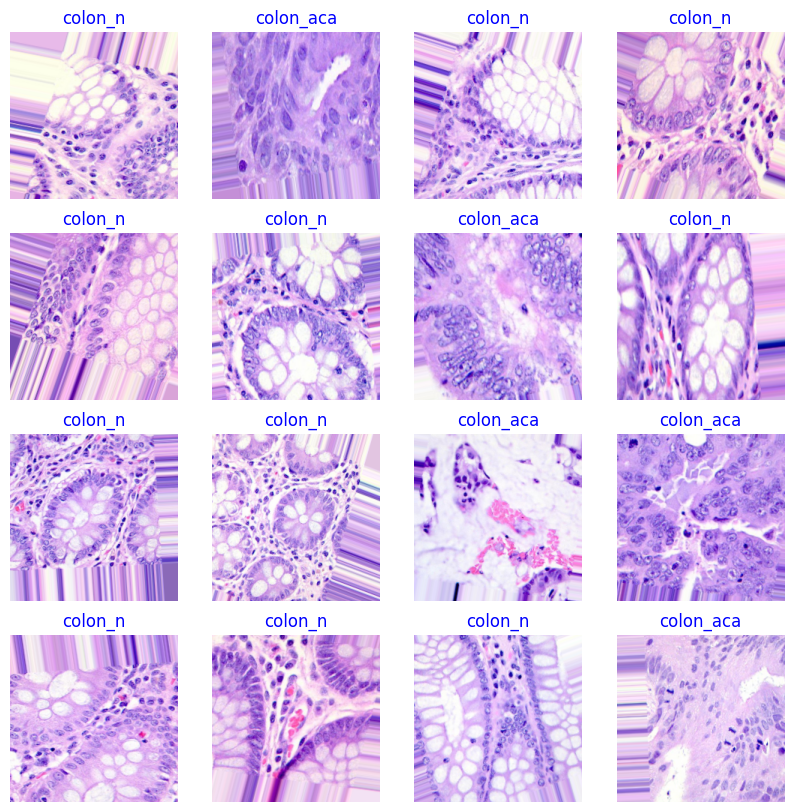

In [ ]:
g_dict = train_gen.class_indices  # Les clés du dict sont les noms des classes et les val sont les indices associés à chaque classe.
classes = list(g_dict.keys())     # definir liste contenant les noms des classes à partir des clés du dict, (classes names : string)
images, labels = next(train_gen)  # extraire un lot d'images et de leurs étiquettes du générateur de données "train_gen".

plt.figure(figsize= (10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)      #  sous-plot avec 4 lignes et 4 colonnes, positionné en fonction de l'index i.
    #image = images[i] / 255       # normalise les pixels d'images en les divisant par 255, ce qui les ramène à la plage [0, 1].
    plt.imshow(images[i])
    index = np.argmax(labels[i])  # extraire l'indice de la classe réelle de l'image
    class_name = classes[index]   # obtenir la classe correspondante à partir de la liste classes.
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')               # désactive les axes du sous-plot
plt.show()

**Model Build :**

In [ ]:
# CNN Model
img_shape = (224, 224, 3)

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

**Model Training :**



*   Le callback **EarlyStopping** permet de stopper l'entraînement du modèle dès qu'il commence à l overfiting .
*   Le callback **ModelCheckpoint** permet de sauvegarder le modèle à chaque époque ou lorsqu'il obtient la meilleure performance sur les données de validation.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Compiling the model with binary_crossentropy as the loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')


# Training the model

history = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=valid_gen,
    validation_steps=None,
    callbacks=[early_stop, model_checkpoint]
)



Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5225
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
100/100 [==============================] - 139s 1s/step - loss: 0.6927 - accuracy: 0.5225 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5189
Epoch 2: val_accuracy did not improve from 0.50000
100/100 [==============================] - 131s 1s/step - loss: 0.6926 - accuracy: 0.5189 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.5673
Epoch 3: val_accuracy improved from 0.50000 to 0.84343, saving model to best_model.h5
100/100 [==============================] - 127s 1s/step - loss: 0.6687 - accuracy: 0.5673 - val_loss: 0.5190 - val_accuracy: 0.8434
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7231


In [ ]:
#Model interpretation
h=history.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

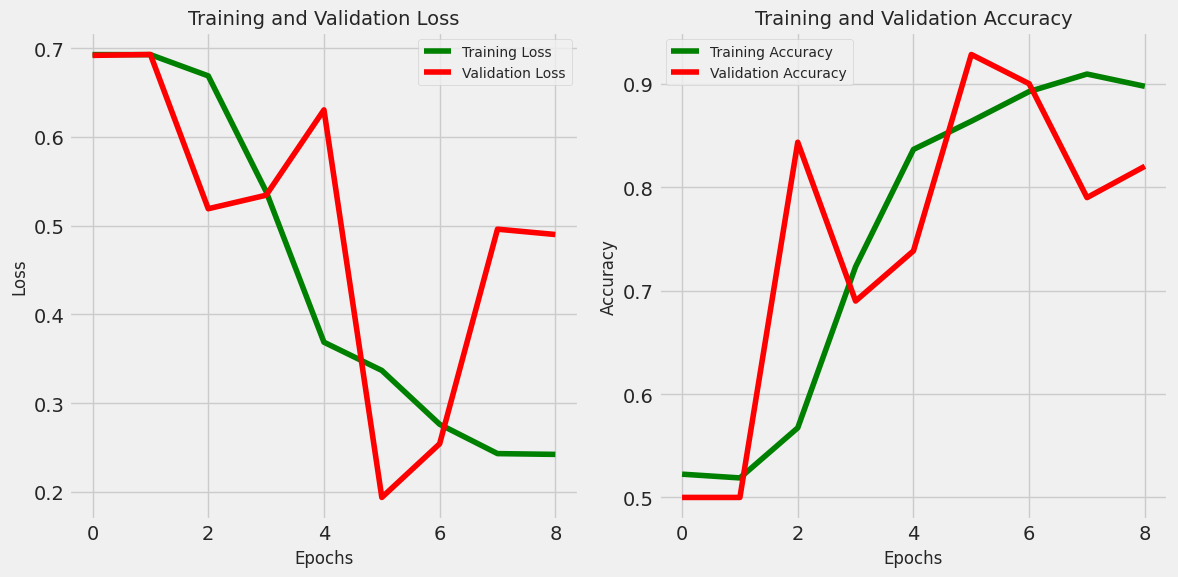

In [ ]:
import matplotlib.pyplot as plt

# Créer une figure et une grille de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Style pour les graphiques
plt.style.use('fivethirtyeight')

# Graphique de perte
axs[0].plot(h['loss'],c='g' , label='Training Loss')
axs[0].plot(h['val_loss'], c='red', label='Validation Loss')
axs[0].set_title('Training and Validation Loss', fontsize=14)  # Taille du titre
axs[0].set_xlabel('Epochs', fontsize=12)  # Taille du label de l'axe x
axs[0].set_ylabel('Loss', fontsize=12)  # Taille du label de l'axe y
axs[0].legend(fontsize=10)

# Graphique d'exactitude
axs[1].plot(h['accuracy'],c='g' ,label='Training Accuracy')
axs[1].plot(h['val_accuracy'], c='red', label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy', fontsize=14)  # Taille du titre
axs[1].set_xlabel('Epochs', fontsize=12)  # Taille du label de l'axe x
axs[1].set_ylabel('Accuracy', fontsize=12)  # Taille du label de l'axe y
axs[1].legend(fontsize=10)

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [ ]:

#Model accurancy
from keras.models import load_model
bestmodel=load_model('best_model.h5')



**Model Accurancy :**

In [ ]:
acc=bestmodel.evaluate_generator(test_gen)[1]
print(f"the accuracy of our model is : {acc*100}%")

the accuracy of our model is : 91.6161596775055%


**Evaluate Model:**

In [ ]:
# Define test set length
test_length = len(test_df)

# Calculate maximum batch size for test set evaluation
test_batch_size = max(n for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80)

# Calculate evaluation steps for test set
test_steps = test_length // test_batch_size

# Evaluate model on train, valid, and test sets
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print train, valid, and test scores
print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print('-' * 20)
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print('-' * 20)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])


1/1 [==============================] - 0s 397ms/step - loss: 0.1401 - accuracy: 0.9375
Train Loss: 0.22431056201457977
Train Accuracy: 0.875
--------------------
Validation Loss: 0.10245038568973541
Validation Accuracy: 1.0
--------------------
Test Loss: 0.1401381641626358
Test Accuracy: 0.9375


In [ ]:
train_gen.class_indices


{'colon_aca': 0, 'colon_n': 1}

1/1 [==============================] - 0s 214ms/step


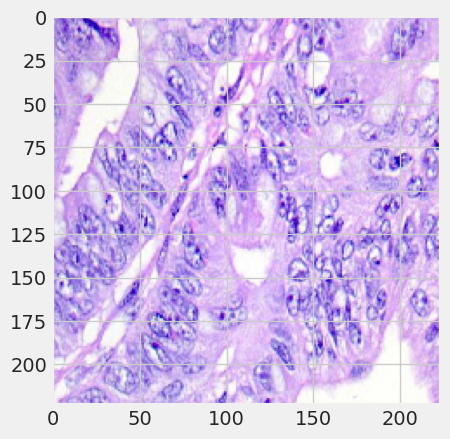

The image is predicted to have colon cancer.


In [ ]:
# Importing necessary libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define the path to the image
path = "/content/test/colon_aca/colonca1018.jpeg"

# Load the image and resize it to the target size
img = load_img(path, target_size=(224, 224))

# Convert the image to an array and normalize the pixel values
img_array = img_to_array(img) / 255

# Predict using the model
pred = model.predict(img_array.reshape(1, 224, 224, 3))

# Visualize the image
plt.imshow(img)
plt.show()

# Check the prediction and print the result
if pred[0][0] >= 0.5:
    print("The image is predicted to have colon cancer.")
else:
    print("The image is predicted not to have colon cancer.")


1/1 [==============================] - 0s 37ms/step


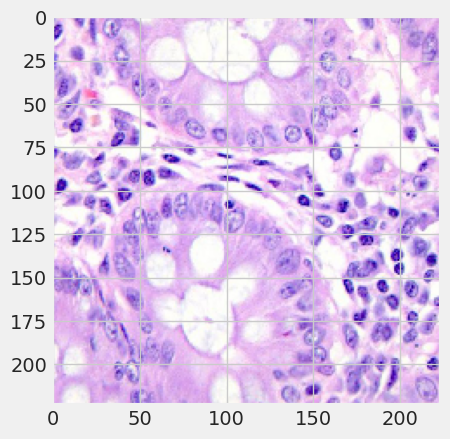

The image is predicted not to have colon cancer.


In [ ]:
# Importing necessary libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define the path to the image
path = "/content/test/colon_n/colonn1036.jpeg"

# Load the image and resize it to the target size
img = load_img(path, target_size=(224, 224))

# Convert the image to an array and normalize the pixel values
img_array = img_to_array(img) / 255

# Predict using the model
pred = model.predict(img_array.reshape(1, 224, 224, 3))

# Visualize the image
plt.imshow(img)
plt.show()

# Check the prediction and print the result
if pred[0][0] >= 0.5:
    print("The image is predicted to have colon cancer.")
else:
    print("The image is predicted not to have colon cancer.")


**Confusion matrics :**

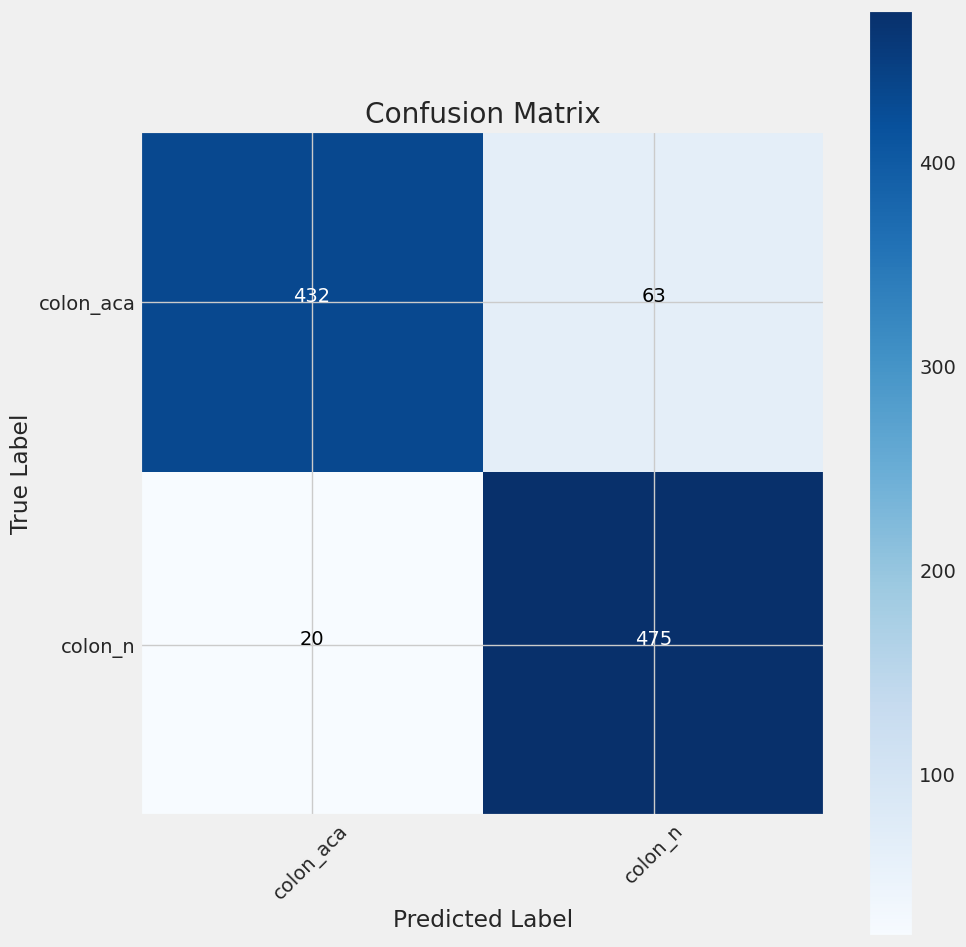

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (5, 5                     ))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

**Transfer Learning :**

**EfficientNet Model**

In [ ]:
path_dir = '/content/train'
train_df = generate_data(path_dir)
path_dir = '/content/valid'
valid_df = generate_data(path_dir)
path_dir = '/content/test'
test_df = generate_data(path_dir)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 7990 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.


In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

In [ ]:
train_df.shape

(7990, 2)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_efficient.h5', monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')

In [ ]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    steps_per_epoch = 100,
                    validation_steps= None,
                    callbacks=[early_stop, model_checkpoint],
                    shuffle= False)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 6.3127 - accuracy: 0.9362
Epoch 1: val_accuracy improved from -inf to 0.97778, saving model to best_model_efficient.h5
100/100 [==============================] - 538s 5s/step - loss: 6.3127 - accuracy: 0.9362 - val_loss: 5.1110 - val_accuracy: 0.9778
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 4.3082 - accuracy: 0.9675
Epoch 2: val_accuracy improved from 0.97778 to 0.99899, saving model to best_model_efficient.h5
100/100 [==============================] - 514s 5s/step - loss: 4.3082 - accuracy: 0.9675 - val_loss: 3.7859 - val_accuracy: 0.9990
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 3.1602 - accuracy: 0.9894
Epoch 3: val_accuracy improved from 0.99899 to 1.00000, saving model to best_model_efficient.h5
100/100 [==============================] - 515s 5s/step - loss: 3.1602 - accuracy: 0.9894 - val_loss: 2.8124 - val_accuracy: 1.0000
Epoch 4/10
100/100 [===========

**Evaluate Model :**

In [ ]:
# Define test set length
test_length = len(test_df)

# Calculate maximum batch size for test set evaluation
test_batch_size = max(n for n in range(1, test_length + 1) if test_length % n == 0 and test_length / n <= 80)

# Calculate evaluation steps for test set
test_steps = test_length // test_batch_size

# Evaluate model on train, valid, and test sets
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print train, valid, and test scores
print("Train Loss:", train_score[0])
print("Train Accuracy:", train_score[1])
print('-' * 20)
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print('-' * 20)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])


1/1 [==============================] - 2s 2s/step - loss: 0.3847 - accuracy: 1.0000
Train Loss: 0.38923180103302
Train Accuracy: 1.0
--------------------
Validation Loss: 0.39040178060531616
Validation Accuracy: 1.0
--------------------
Test Loss: 0.38469547033309937
Test Accuracy: 1.0


In [ ]:
model.load_weights('best_model_effisient.h5')
model.evaluate(test_gen)

62/62 [==============================] - 139s 2s/step - loss: 3.3063 - accuracy: 1.0000


[3.306304454803467, 1.0]

In [ ]:

#Model accurancy
from keras.models import load_model
bestmodel=load_model('best_model_effisient.h5')

acc=bestmodel.evaluate_generator(test_gen)[1]
print(f"the accuracy of our model is : {acc*100}%")

the accuracy of our model is : 100.0%


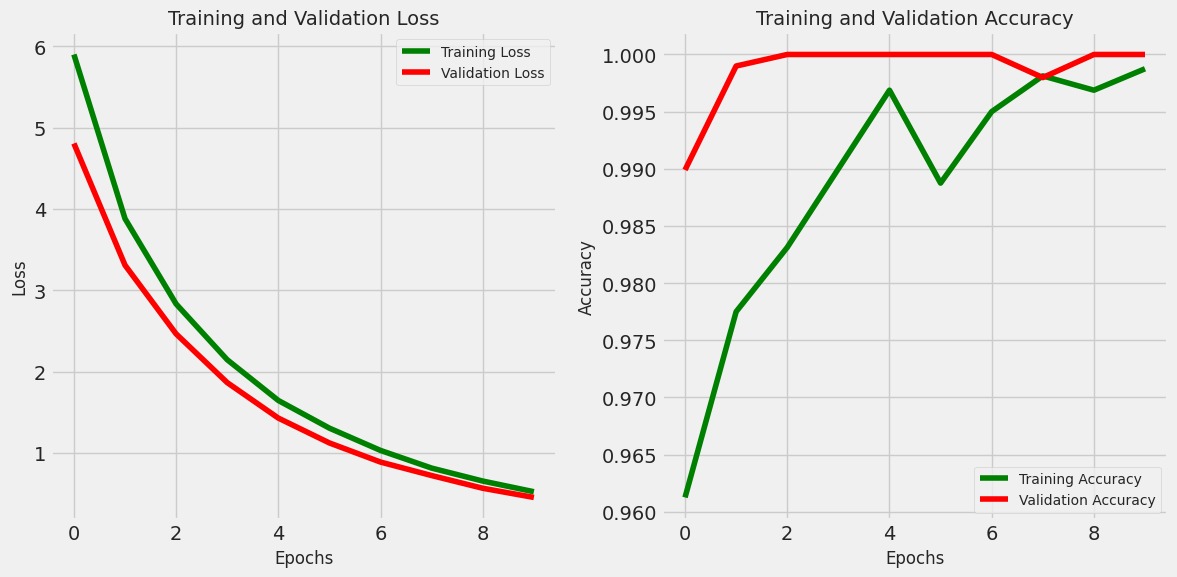

In [ ]:
import matplotlib.pyplot as plt

h=history.history
h.keys()

# Créer une figure et une grille de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Style pour les graphiques
plt.style.use('fivethirtyeight')

# Graphique de perte
axs[0].plot(h['loss'],c='g' , label='Training Loss')
axs[0].plot(h['val_loss'], c='red', label='Validation Loss')
axs[0].set_title('Training and Validation Loss', fontsize=14)  # Taille du titre
axs[0].set_xlabel('Epochs', fontsize=12)  # Taille du label de l'axe x
axs[0].set_ylabel('Loss', fontsize=12)  # Taille du label de l'axe y
axs[0].legend(fontsize=10)

# Graphique d'exactitude
axs[1].plot(h['accuracy'],c='g' ,label='Training Accuracy')
axs[1].plot(h['val_accuracy'], c='red', label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy', fontsize=14)  # Taille du titre
axs[1].set_xlabel('Epochs', fontsize=12)  # Taille du label de l'axe x
axs[1].set_ylabel('Accuracy', fontsize=12)  # Taille du label de l'axe y
axs[1].legend(fontsize=10)

# Afficher les graphiques
plt.tight_layout()
plt.show()


1/1 [==============================] - 4s 4s/step


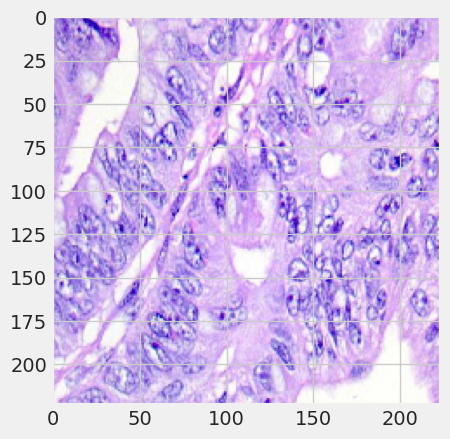

The image is predicted to have colon cancer.


In [ ]:
# Importing necessary libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define the path to the image
path = "/content/test/colon_aca/colonca1018.jpeg"

# Load the image and resize it to the target size
img = load_img(path, target_size=(224, 224))

# Convert the image to an array and normalize the pixel values
img_array = img_to_array(img) / 255

# Predict using the model
pred = model.predict(img_array.reshape(1, 224, 224, 3))

# Visualize the image
plt.imshow(img)
plt.show()

# Check the prediction and print the result
if pred[0][0] >= 0.5:
    print("The image is predicted to have colon cancer.")
else:
    print("The image is predicted not to have colon cancer.")


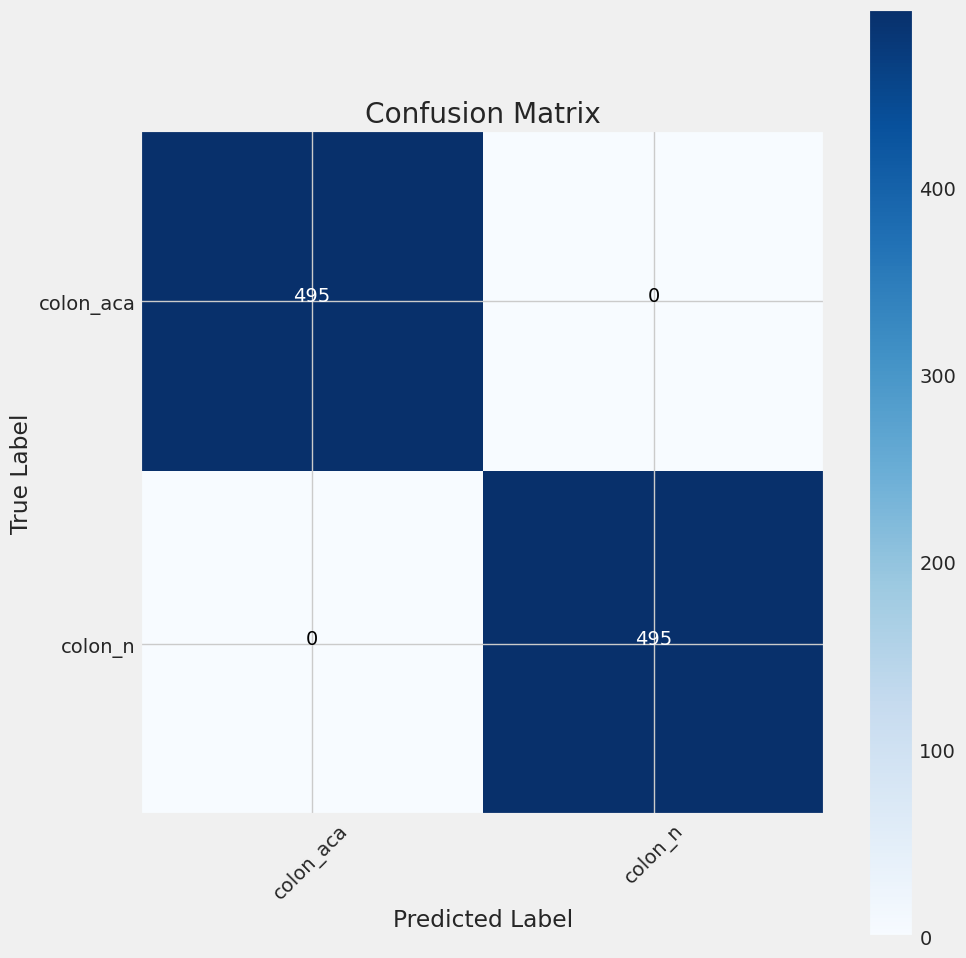

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()